In [1]:
import pyart
import os
import numpy as np
from matplotlib import pyplot as plt
from __future__ import print_function
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, DayLocator, HourLocator, DateFormatter, drange
from matplotlib.colors import LogNorm
import netCDF4
from copy import deepcopy
from mpl_toolkits.basemap import Basemap, pyproj

import dateutil.parser
%matplotlib inline

In [2]:
status_dir = '/Users/scollis/temp/status/'
all_files = os.listdir(status_dir)
all_files.sort()
max_rf =[]
mean_rf = []
good_files = []
datetimes = []
for filen in all_files:
    fh = open(status_dir+filen)
    line = fh.readline()[23::]
    fh.close()
    try:
        p1 = float(line.split(' ')[0])
        p2 = float(line.split(' ')[1])
        max_rf.append(p1)
        mean_rf.append(p2)
        good_files.append(filen)
        datetimes.append(datetime.datetime.strptime(filen[4:-11], '%Y%m%d_%H%M%S'))
    except:
        pass
    
mean_rf = np.array(mean_rf)
max_rf = np.array(max_rf)
datetimes = np.array(datetimes)

In [3]:
closest_ts = deepcopy(datetimes)
for i in range(len(closest_ts)):
    if closest_ts[i].hour in np.arange(12) + 6:
        closest_ts[i] = datetime.datetime(closest_ts[i].year, closest_ts[i].month,
                                          closest_ts[i].day, 12)
    else:
        closest_ts[i] = datetime.datetime(closest_ts[i].year, closest_ts[i].month,
                                          closest_ts[i].day, 0)

In [4]:
pattern = 'http://nomads.ncdc.noaa.gov/thredds/dodsC/narr-a/%Y%m/%Y%m%d/narr-a_221_%Y%m%d_%H00_000.grb'
thredds_addy = [obj.strftime(pattern) for obj in closest_ts]

In [5]:
dataset_test = netCDF4.Dataset(thredds_addy[10])

In [6]:
xg, yg = np.meshgrid(dataset_test.variables['x'][:]*1000.0, dataset_test.variables['y'][:]*1000.0)
pnyc = pyproj.Proj(
     proj='lcc',
     datum='NAD83',
     lat_0=50.0,
     lat_1=50.0,
     lat_2=50.0,
     lon_0=-107.0)

lons, lats = pnyc(xg ,
                  yg , inverse=True)
lons[np.where(lons >= 0)] = lons[np.where(lons >= 0)] -360.
pm_lat = 43.6667
pm_lon = -70.2667
cf = abs(lons - pm_lon) + abs(lats - pm_lat)
loc = np.where(cf == cf.min())


In [7]:
height_resolved = []
for key in dataset_test.variables.keys():
    if 29 in dataset_test.variables[key].shape and len(dataset_test.variables[key].shape) == 4:
        height_resolved.append(key)
#height_resolved = ['Temperature', 'Temperature_height_above_ground']
#(u'time', u'height_above_ground2', u'y', u'x')
sfc_only = [ 'Convective_available_potential_energy_surface']


In [ ]:
hrs = dataset_test.variables[height_resolved[0]].shape
sfcs = dataset_test.variables[sfc_only[0]].shape
dataset_test.close()
ta_array = np.array(thredds_addy)
uta = np.unique(ta_array)

In [ ]:
data_dict = {}
for key in height_resolved:
    data_dict.update({key : np.zeros([29, len(uta)])})
for key in sfc_only:
    data_dict.update({key : np.zeros([len(uta)])})

for i in range(len(uta)):
    dataset = netCDF4.Dataset(uta[i])
    for key in height_resolved:
        #print(key, dataset.variables[key].shape)
        data_dict[key][:,i] = dataset.variables[key][0,:,loc[0][0], loc[1][0]]
    for key in sfc_only:
        #print(key, dataset.variables[key].shape)
        data_dict[key][i] = dataset.variables[key][0,loc[0][0], loc[1][0]]
    
    dataset.close()
    

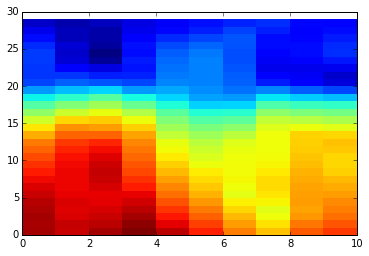

In [58]:
plt.pcolor(data_dict['Temperature'])

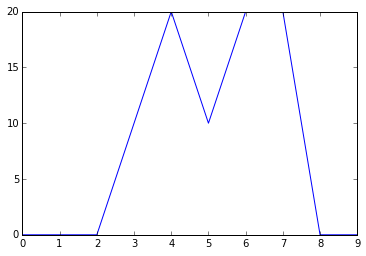

In [62]:
plt.plot(data_dict['Convective_available_potential_energy_surface'])

In [64]:
print(len(uta))

733
